In [1]:
import sncosmo
from   astropy.table import Table
import numpy as np
import matplotlib.pylab as plt

obs = Table({'time' : [56176.19, 56188.254, 56207.172],
             'band' : ['desg', 'desr', 'desi'],
             'gain' : [1., 1., 1.],
             'skynoise': [191.27, 147.62, 160.40],
             'zp'   : [30., 30., 30.],
             'zpsys':['ab', 'ab', 'ab']})

model  = sncosmo.Model(source='salt2')

### Reading SNTable in

In [2]:
filename = "/global/homes/a/anitab/DC2_run1p1_TransientDocs/Notebooks/Hosted_SN_table.csv"
from pandas import read_csv

In [3]:
vvv  = read_csv(filename)
data = vvv['galaxy_id c mB t0 x0 x1 z random_Hosting rand_host zbin "Unnamed: 0" diskMassStellar morphology/diskHalfLightRadiusArcsec morphology/diskMinorAxisArcsec morphology/positionAngle morphology/spheroidHalfLightRadiusArcsec morphology/spheroidMinorAxisArcsec size_bulge_true size_disk_true totalMassStellar uniqueId raJ2000_gal decJ2000_gal z zbin_gals snid']

In [4]:
vvv.columns

Index(['galaxy_id c mB t0 x0 x1 z random_Hosting rand_host zbin "Unnamed: 0" diskMassStellar morphology/diskHalfLightRadiusArcsec morphology/diskMinorAxisArcsec morphology/positionAngle morphology/spheroidHalfLightRadiusArcsec morphology/spheroidMinorAxisArcsec size_bulge_true size_disk_true totalMassStellar uniqueId raJ2000_gal decJ2000_gal z zbin_gals snid'], dtype='object')

In [5]:
length = 1000 #len(data)
zvals  = np.zeros(length) 
x0vals = np.zeros(length)
x1vals = np.zeros(length)
cvals  = np.zeros(length)
mBvals = np.zeros(length)
t0vals = np.zeros(length)
smass  = np.zeros(length)

for i in range(length):
    zvals[i]  = data[i].split()[6]
    x0vals[i] = data[i].split()[4]
    x1vals[i] = data[i].split()[5]
    cvals[i]  = data[i].split()[1]
    mBvals[i] = data[i].split()[2]
    t0vals[i] = data[i].split()[3]
    smass[i]  = data[i].split()[20]

In [ ]:
"""
print (" z limits: ")
print (np.min(zvals))
print (np.max(zvals))
print ()

print (" x0 limits: ")
print (np.min(x0vals))
print (np.max(x0vals))
print ()

print (" x1 limits: ")
print (np.min(x1vals))
print (np.max(x1vals))
print ()

print (" c limits: ")
print (np.min(cvals))
print (np.max(cvals))
print ()

print (" mB limits: ")
print (np.min(mBvals))
print (np.max(mBvals))
print ()
"""

In [6]:
params = []
for j, z in enumerate(zvals):
    mabs = mBvals[j] #np.random.normal(-19.3, 0.3)
    model.set(z=z)
    model.set_source_peakabsmag(mabs, 'bessellb', 'ab')
    x0 = model.get('x0')
    p = {'z':z, 't0':t0vals[j], 'x0':x0, 'x1': x1vals[j], 'c': cvals[j]}
    params.append(p)

#for p in params:
#    print (p)

In [7]:
lcs = sncosmo.realize_lcs(obs, model, params)
print (lcs[0])

   time   band      flux      fluxerr  zp  zpsys
--------- ---- -------------- ------- ---- -----
 56176.19 desg -37.7169472029  191.27 30.0    ab
56188.254 desr -52.5674032656  147.62 30.0    ab
56207.172 desi  58.1523414362   160.4 30.0    ab


In [8]:
from   astropy.cosmology import WMAP9 as cosmo
import astropy.units as u

def mu2(x0, x1, c,z, smassval):
    alpha  = 0.141
    beta   = 3.101
    DeltaM = -0.07
    mB     = 10.635 - (2.5 * np.log10(x0))
    dist   = cosmo.comoving_distance(lcs[0].meta['z'])
    dist  *= (1./u.Mpc)
    if smassval < 1e10:
        MB = -19.05
    else:
        MB = -19.05 + DeltaM
    val   = mB - (MB - (alpha * x1) + (beta * c))
    return val

Adding the condition on stellar mass did not change the distance modulus by anything noticable since the difference between MB value when considering stellar mass of the host galaxy or not was very small so it was expected, unfortunately!

In [9]:
vals = np.zeros(length)
zs   = np.zeros(length)
x0s  = np.zeros(length)
x1s  = np.zeros(length)
cs   = np.zeros(length)

mu = np.vectorize(mu2)

for i in range(length):
    vals[i] = mu(lcs[i].meta['x0'], lcs[i].meta['x1'], lcs[i].meta['c'], lcs[i].meta['z'], smass[i])
    zs[i]   = lcs[i].meta['z']
    x0s[i]  = lcs[i].meta['x0']
    x1s[i]  = lcs[i].meta['x1']
    cs[i]   = lcs[i].meta['c']

In [10]:
np.min(zs)

0.033126589233066606

### Distance modulus from theory

In [11]:
from   scipy              import interpolate, integrate

h  = 0.6726
H0 = h*100.

def chi_integrand(zprime):
    '''
    Parameters
    -------------------------------------------------------------------------------------------------
        zprime: redshift values
        
    Return
    -------------------------------------------------------------------------------------------------
        Integrand of integral part in luminosity distance in Equation (3) in Kosowsky 2011.
        d(zprime)/ E(zprime)
    '''

    omegam = 0.316
    omegav = 0.684
    val    = 1./(np.sqrt(omegam*(1+zprime)**3 + omegav))
    return val

def chi_integral(z):
    '''
    Parameters
    -------------------------------------------------------------------------------------------------
        z: redshift
        
    Return
    -------------------------------------------------------------------------------------------------
        Integral of the integral in luminsoty distance in Equation (3) in Kosowsky 2011.
        d(zprime)/ E(zprime) integrated from 0 to z
    '''
    
    c       = 3e5 #km/s
    val,err = integrate.quad(chi_integrand,0,z)
    return val

def mu_kosowsky(z):
    '''
    Parameters
    -------------------------------------------------------------------------------------------------
        z: redshift
        
    Return
    -------------------------------------------------------------------------------------------------
        Distance modulus (mu) obtained from Equation (2) in Kosowsky
    '''
    
    c   = 3e5
    righthandside = (1+z) * (c/H0) * chi_integral(z)
    val = 2.17 * np.log(righthandside) + 25.
    return val

#### 3rd polynomial fit to points

In [12]:
indx = np.arange(0,length)
Z = [x for _,x in sorted(zip(zvals,indx))]

z = np.polyfit(np.sort(zs), vals[Z], 3)
p = np.poly1d(z)

#### Plotting mu(z) vs z from SNTable 

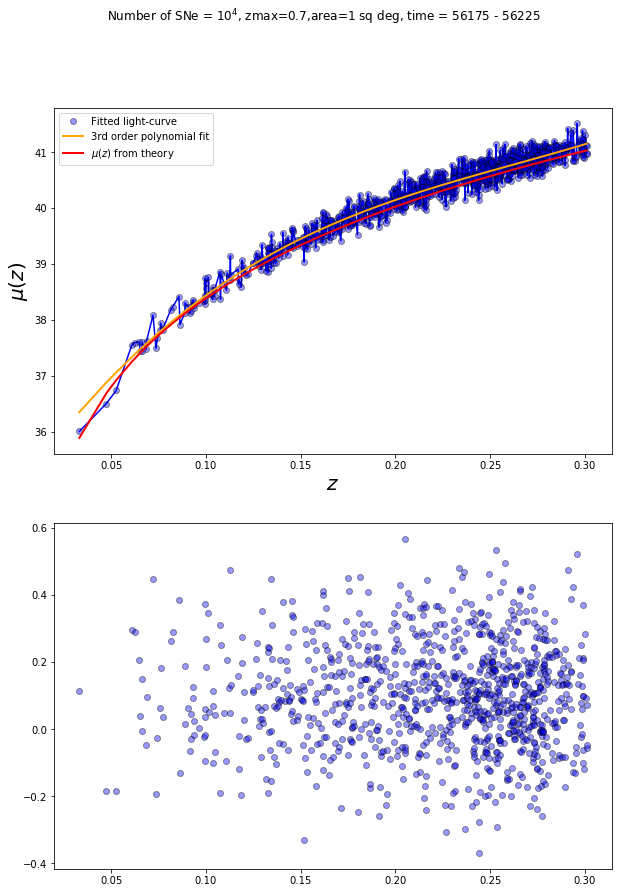

In [13]:
plt.figure(4, figsize=(10,14))


plt.subplot(211)
# SNTable points fitted
plt.plot(np.sort(zs), vals[Z], "b", label="")
plt.plot(zs, vals, "bo", alpha=0.4, markeredgecolor="black", label="Fitted light-curve")

plt.xlabel("$z$", fontsize=20)
plt.ylabel("$\mu(z)$", fontsize=20)
plt.suptitle("Number of SNe = $10^4$, zmax=0.7,area=1 sq deg, time = 56175 - 56225")

# polynomial fit curve
plt.plot(np.sort(zs), p(np.sort(zs)), color="orange", lw=2, label="3rd order polynomial fit")

# theory curve
mu_kosowsky_vec = np.vectorize(mu_kosowsky)
plt.plot(np.sort(zs), mu_kosowsky_vec(np.sort(zs)), color="red", lw=2, label="$\mu(z)$ from theory")
plt.legend(loc='best')

#plt.savefig("mu_z_sne_params_SNTable.png", dpi=800)

plt.subplot(212)
plt.plot(np.sort(zs), vals[Z] -  mu_kosowsky_vec(np.sort(zs)), "bo", markeredgecolor="black", alpha=0.4)

#### Checking $\mu(z)$ values to compare with JLA

In [ ]:
print ("mu(z=0.1) = ", mu_kosowsky(0.1))
print ("mu(z=0.2) = ", mu_kosowsky(0.2))
print ("mu(z=0.4) = ", mu_kosowsky(0.4))
print ("mu(z=0.6) = ", mu_kosowsky(0.6))

Comparing this with values from JLA (http://supernovae.in2p3.fr/sdss_snls_jla/ReadMe.html) shows that my distance modulus plot is in agreement with actual supernovae data so I am convinced that this function works fine!

In [14]:
data1 = lcs

In [15]:
data1[0]

time,band,flux,fluxerr,zp,zpsys
float64,str4,float64,float64,float64,str2
56176.19,desg,-37.7169472029,191.27,30.0,ab
56188.254,desr,-52.5674032656,147.62,30.0,ab
56207.172,desi,58.1523414362,160.4,30.0,ab


In [ ]:
#from astropy.io import ascii
#ascii.write(data1, 'blah.dat', names=['time', 'band', 'flux', 'fluxerr','zp', 'zpsys'])

In [16]:
x0err = np.zeros(length)
x1err = np.zeros(length)
cerr  = np.zeros(length)
t0err = np.zeros(length)
counter = []

for w in range(length):
    try:
        result, fitted_model = sncosmo.fit_lc(data1[w], model, ['t0', 'x0', 'x1', 'c'], minsnr = 0.01)
        x0err[w] = result['errors']['x0'] 
        x1err[w] = result['errors']['x1'] 
        cerr[w]  = result['errors']['c'] 
        t0err[w] = result['errors']['t0'] 
        counter.append(w)
    except:
        print ("number = ", w)
        pass

number =  2
number =  8
number =  10


/global/common/software/lsst/cori-haswell-gcc/stack/w.2018.13_sims2.7.0/stack/miniconda3-4.3.21-10a4fa6/Linux64/sncosmo/12.0-1-g5e70e90+4/lib/python/sncosmo-1.3.0-py3.6-linux-x86_64.egg/sncosmo/models.py:670: RuntimeWarning: overflow encountered in power
  self._model['clbase'](wave)**self._parameters[2])
/global/common/software/lsst/cori-haswell-gcc/stack/w.2018.13_sims2.7.0/stack/miniconda3-4.3.21-10a4fa6/Linux64/sncosmo/12.0-1-g5e70e90+4/lib/python/sncosmo-1.3.0-py3.6-linux-x86_64.egg/sncosmo/models.py:136: RuntimeWarning: invalid value encountered in multiply
  fsum = np.sum(f * b.trans * b.wave * b.dwave, axis=1) / HC_ERG_AA
/global/common/software/lsst/cori-haswell-gcc/stack/w.2018.13_sims2.7.0/stack/miniconda3-4.3.21-10a4fa6/Linux64/sncosmo/12.0-1-g5e70e90+4/lib/python/sncosmo-1.3.0-py3.6-linux-x86_64.egg/sncosmo/fitting.py:428: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.283534
    t0 = +56224.895060
    x0 = +343064766.296997
    x1 = +3

number =  13


/global/common/software/lsst/cori-haswell-gcc/stack/w.2018.13_sims2.7.0/stack/miniconda3-4.3.21-10a4fa6/Linux64/sncosmo/12.0-1-g5e70e90+4/lib/python/sncosmo-1.3.0-py3.6-linux-x86_64.egg/sncosmo/fitting.py:428: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.283534
    t0 = +56115.625365
    x0 = +2490680805.310750
    x1 = +729.423260
     c = -32483.095340

  d, l = m.migrad(ncall=maxcall)


number =  19
number =  24
number =  27
number =  30
number =  33
number =  37


/global/common/software/lsst/cori-haswell-gcc/stack/w.2018.13_sims2.7.0/stack/miniconda3-4.3.21-10a4fa6/Linux64/sncosmo/12.0-1-g5e70e90+4/lib/python/sncosmo-1.3.0-py3.6-linux-x86_64.egg/sncosmo/fitting.py:428: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.283534
    t0 = +56115.305219
    x0 = +354909757.245260
    x1 = -14.554228
     c = -231.825137

  d, l = m.migrad(ncall=maxcall)


number =  39
number =  40
number =  46
number =  47
number =  48
number =  50
number =  54
number =  78
number =  79
number =  88
number =  90
number =  92
number =  95
number =  104
number =  119
number =  130
number =  131


/global/common/software/lsst/cori-haswell-gcc/stack/w.2018.13_sims2.7.0/stack/miniconda3-4.3.21-10a4fa6/Linux64/sncosmo/12.0-1-g5e70e90+4/lib/python/sncosmo-1.3.0-py3.6-linux-x86_64.egg/sncosmo/fitting.py:428: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.283534
    t0 = +56199.308059
    x0 = +7051523536.484541
    x1 = -18.002166
     c = -20626.367118

  d, l = m.migrad(ncall=maxcall)


number =  137
number =  138


/global/common/software/lsst/cori-haswell-gcc/stack/w.2018.13_sims2.7.0/stack/miniconda3-4.3.21-10a4fa6/Linux64/sncosmo/12.0-1-g5e70e90+4/lib/python/sncosmo-1.3.0-py3.6-linux-x86_64.egg/sncosmo/fitting.py:428: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.283534
    t0 = +56123.166360
    x0 = +982362633.796454
    x1 = -232.120581
     c = -1963.792195

  d, l = m.migrad(ncall=maxcall)


number =  140


/global/common/software/lsst/cori-haswell-gcc/stack/w.2018.13_sims2.7.0/stack/miniconda3-4.3.21-10a4fa6/Linux64/sncosmo/12.0-1-g5e70e90+4/lib/python/sncosmo-1.3.0-py3.6-linux-x86_64.egg/sncosmo/fitting.py:42: RuntimeWarning: overflow encountered in square
  return np.sum(((data['flux'] - mflux) / data['fluxerr'])**2)
/global/common/software/lsst/cori-haswell-gcc/stack/w.2018.13_sims2.7.0/stack/miniconda3-4.3.21-10a4fa6/Linux64/sncosmo/12.0-1-g5e70e90+4/lib/python/sncosmo-1.3.0-py3.6-linux-x86_64.egg/sncosmo/fitting.py:428: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.283534
    t0 = +56219.253892
    x0 = -0.011728
    x1 = +11.245609
     c = -150.138996

  d, l = m.migrad(ncall=maxcall)


number =  149
number =  152
number =  153
number =  167
number =  180
number =  183


/global/common/software/lsst/cori-haswell-gcc/stack/w.2018.13_sims2.7.0/stack/miniconda3-4.3.21-10a4fa6/Linux64/sncosmo/12.0-1-g5e70e90+4/lib/python/sncosmo-1.3.0-py3.6-linux-x86_64.egg/sncosmo/fitting.py:428: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.283534
    t0 = +56184.819092
    x0 = +175795971.007127
    x1 = +6.150709
     c = -214.067341

  d, l = m.migrad(ncall=maxcall)
/global/common/software/lsst/cori-haswell-gcc/stack/w.2018.13_sims2.7.0/stack/miniconda3-4.3.21-10a4fa6/Linux64/sncosmo/12.0-1-g5e70e90+4/lib/python/sncosmo-1.3.0-py3.6-linux-x86_64.egg/sncosmo/fitting.py:428: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.283534
    t0 = +56229.745832
    x0 = +4108585.708653
    x1 = -12.713978
     c = -152.116795

  d, l = m.migrad(ncall=maxcall)


number =  187
number =  188
number =  189
number =  190


/global/common/software/lsst/cori-haswell-gcc/stack/w.2018.13_sims2.7.0/stack/miniconda3-4.3.21-10a4fa6/Linux64/sncosmo/12.0-1-g5e70e90+4/lib/python/sncosmo-1.3.0-py3.6-linux-x86_64.egg/sncosmo/fitting.py:428: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.283534
    t0 = +56163.811548
    x0 = +66014496730.965088
    x1 = -134.287903
     c = +9609.371597

  d, l = m.migrad(ncall=maxcall)


number =  196
number =  197
number =  204
number =  227
number =  228
number =  229
number =  232


/global/common/software/lsst/cori-haswell-gcc/stack/w.2018.13_sims2.7.0/stack/miniconda3-4.3.21-10a4fa6/Linux64/sncosmo/12.0-1-g5e70e90+4/lib/python/sncosmo-1.3.0-py3.6-linux-x86_64.egg/sncosmo/fitting.py:428: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.283534
    t0 = +56112.484345
    x0 = +0.000198
    x1 = -3187.859832
     c = -588.581238

  d, l = m.migrad(ncall=maxcall)


number =  237
number =  253
number =  254


/global/common/software/lsst/cori-haswell-gcc/stack/w.2018.13_sims2.7.0/stack/miniconda3-4.3.21-10a4fa6/Linux64/sncosmo/12.0-1-g5e70e90+4/lib/python/sncosmo-1.3.0-py3.6-linux-x86_64.egg/sncosmo/fitting.py:428: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.283534
    t0 = +56222.666302
    x0 = -3428444521.991115
    x1 = +21.211682
     c = +4766.783582

  d, l = m.migrad(ncall=maxcall)


number =  258
number =  260


/global/common/software/lsst/cori-haswell-gcc/stack/w.2018.13_sims2.7.0/stack/miniconda3-4.3.21-10a4fa6/Linux64/sncosmo/12.0-1-g5e70e90+4/lib/python/sncosmo-1.3.0-py3.6-linux-x86_64.egg/sncosmo/fitting.py:428: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.283534
    t0 = +56200.705345
    x0 = +4908417203.961109
    x1 = -159.584973
     c = +416610.888311

  d, l = m.migrad(ncall=maxcall)


number =  262
number =  272
number =  274
number =  279


/global/common/software/lsst/cori-haswell-gcc/stack/w.2018.13_sims2.7.0/stack/miniconda3-4.3.21-10a4fa6/Linux64/sncosmo/12.0-1-g5e70e90+4/lib/python/sncosmo-1.3.0-py3.6-linux-x86_64.egg/sncosmo/fitting.py:428: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.283534
    t0 = +56227.054212
    x0 = -1747454713.955235
    x1 = -45.719392
     c = -13826.423392

  d, l = m.migrad(ncall=maxcall)


number =  284
number =  296


/global/common/software/lsst/cori-haswell-gcc/stack/w.2018.13_sims2.7.0/stack/miniconda3-4.3.21-10a4fa6/Linux64/sncosmo/12.0-1-g5e70e90+4/lib/python/sncosmo-1.3.0-py3.6-linux-x86_64.egg/sncosmo/fitting.py:428: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.283534
    t0 = +56124.682300
    x0 = +17676904435.874195
    x1 = -101.660072
     c = +18085.145612

  d, l = m.migrad(ncall=maxcall)


number =  305
number =  308
number =  312
number =  327
number =  333


/global/common/software/lsst/cori-haswell-gcc/stack/w.2018.13_sims2.7.0/stack/miniconda3-4.3.21-10a4fa6/Linux64/sncosmo/12.0-1-g5e70e90+4/lib/python/sncosmo-1.3.0-py3.6-linux-x86_64.egg/sncosmo/fitting.py:428: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.283534
    t0 = +56134.050015
    x0 = -35826041104.123642
    x1 = -774.108453
     c = -19542.393125

  d, l = m.migrad(ncall=maxcall)


number =  345
number =  350
number =  358
number =  362
number =  369
number =  379
number =  386
number =  387


/global/common/software/lsst/cori-haswell-gcc/stack/w.2018.13_sims2.7.0/stack/miniconda3-4.3.21-10a4fa6/Linux64/sncosmo/12.0-1-g5e70e90+4/lib/python/sncosmo-1.3.0-py3.6-linux-x86_64.egg/sncosmo/fitting.py:428: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.283534
    t0 = +56228.539701
    x0 = +260447158.749510
    x1 = -129.759660
     c = +14936.518321

  d, l = m.migrad(ncall=maxcall)


number =  392


/global/common/software/lsst/cori-haswell-gcc/stack/w.2018.13_sims2.7.0/stack/miniconda3-4.3.21-10a4fa6/Linux64/sncosmo/12.0-1-g5e70e90+4/lib/python/sncosmo-1.3.0-py3.6-linux-x86_64.egg/sncosmo/fitting.py:428: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.283534
    t0 = +56136.487812
    x0 = +30116677.535621
    x1 = -46.137825
     c = -171.044459

  d, l = m.migrad(ncall=maxcall)
/global/common/software/lsst/cori-haswell-gcc/stack/w.2018.13_sims2.7.0/stack/miniconda3-4.3.21-10a4fa6/Linux64/sncosmo/12.0-1-g5e70e90+4/lib/python/sncosmo-1.3.0-py3.6-linux-x86_64.egg/sncosmo/fitting.py:428: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.283534
    t0 = +56203.279409
    x0 = -322246843.876996
    x1 = +48.722664
     c = +701.659744

  d, l = m.migrad(ncall=maxcall)


number =  398
number =  400
number =  404
number =  417


/global/common/software/lsst/cori-haswell-gcc/stack/w.2018.13_sims2.7.0/stack/miniconda3-4.3.21-10a4fa6/Linux64/sncosmo/12.0-1-g5e70e90+4/lib/python/sncosmo-1.3.0-py3.6-linux-x86_64.egg/sncosmo/fitting.py:428: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.283534
    t0 = +56173.645783
    x0 = -459550088.239067
    x1 = -3.112870
     c = +651.214892

  d, l = m.migrad(ncall=maxcall)


number =  424
number =  428
number =  429


/global/common/software/lsst/cori-haswell-gcc/stack/w.2018.13_sims2.7.0/stack/miniconda3-4.3.21-10a4fa6/Linux64/sncosmo/12.0-1-g5e70e90+4/lib/python/sncosmo-1.3.0-py3.6-linux-x86_64.egg/sncosmo/fitting.py:428: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.283534
    t0 = +56222.187868
    x0 = +620054044.089835
    x1 = +173.814870
     c = +10164.373998

  d, l = m.migrad(ncall=maxcall)


number =  433


/global/common/software/lsst/cori-haswell-gcc/stack/w.2018.13_sims2.7.0/stack/miniconda3-4.3.21-10a4fa6/Linux64/sncosmo/12.0-1-g5e70e90+4/lib/python/sncosmo-1.3.0-py3.6-linux-x86_64.egg/sncosmo/fitting.py:428: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.283534
    t0 = +56179.872945
    x0 = +89905713.398500
    x1 = -11.490827
     c = -243.146708

  d, l = m.migrad(ncall=maxcall)


number =  437
number =  443
number =  444


/global/common/software/lsst/cori-haswell-gcc/stack/w.2018.13_sims2.7.0/stack/miniconda3-4.3.21-10a4fa6/Linux64/sncosmo/12.0-1-g5e70e90+4/lib/python/sncosmo-1.3.0-py3.6-linux-x86_64.egg/sncosmo/fitting.py:428: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.283534
    t0 = +56136.393379
    x0 = +1224276159.935063
    x1 = -51.007031
     c = -250.790771

  d, l = m.migrad(ncall=maxcall)


number =  447
number =  448
number =  460
number =  464
number =  467
number =  473
number =  475
number =  476
number =  492
number =  494
number =  500
number =  506
number =  511


/global/common/software/lsst/cori-haswell-gcc/stack/w.2018.13_sims2.7.0/stack/miniconda3-4.3.21-10a4fa6/Linux64/sncosmo/12.0-1-g5e70e90+4/lib/python/sncosmo-1.3.0-py3.6-linux-x86_64.egg/sncosmo/fitting.py:428: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.283534
    t0 = +56228.473915
    x0 = -18191998839.386734
    x1 = +84.767899
     c = +81217.426331

  d, l = m.migrad(ncall=maxcall)


number =  532
number =  534
number =  535
number =  536
number =  537
number =  539


/global/common/software/lsst/cori-haswell-gcc/stack/w.2018.13_sims2.7.0/stack/miniconda3-4.3.21-10a4fa6/Linux64/sncosmo/12.0-1-g5e70e90+4/lib/python/sncosmo-1.3.0-py3.6-linux-x86_64.egg/sncosmo/fitting.py:428: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.283534
    t0 = +56226.492178
    x0 = +1255183260484.791504
    x1 = -55.898280
     c = +83017.366840

  d, l = m.migrad(ncall=maxcall)
/global/common/software/lsst/cori-haswell-gcc/stack/w.2018.13_sims2.7.0/stack/miniconda3-4.3.21-10a4fa6/Linux64/sncosmo/12.0-1-g5e70e90+4/lib/python/sncosmo-1.3.0-py3.6-linux-x86_64.egg/sncosmo/fitting.py:428: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.283534
    t0 = +56113.130852
    x0 = -446991737.471188
    x1 = -41.697263
     c = -238.093816

  d, l = m.migrad(ncall=maxcall)


number =  541
number =  544
number =  546
number =  547


/global/common/software/lsst/cori-haswell-gcc/stack/w.2018.13_sims2.7.0/stack/miniconda3-4.3.21-10a4fa6/Linux64/sncosmo/12.0-1-g5e70e90+4/lib/python/sncosmo-1.3.0-py3.6-linux-x86_64.egg/sncosmo/fitting.py:428: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.283534
    t0 = +56136.803885
    x0 = -9289296354.441456
    x1 = +24.933960
     c = +63904.578879

  d, l = m.migrad(ncall=maxcall)


number =  553


/global/common/software/lsst/cori-haswell-gcc/stack/w.2018.13_sims2.7.0/stack/miniconda3-4.3.21-10a4fa6/Linux64/sncosmo/12.0-1-g5e70e90+4/lib/python/sncosmo-1.3.0-py3.6-linux-x86_64.egg/sncosmo/fitting.py:428: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.283534
    t0 = +56126.220897
    x0 = -5579102367.855965
    x1 = -4.186555
     c = +7298.245120

  d, l = m.migrad(ncall=maxcall)


number =  559
number =  574


/global/common/software/lsst/cori-haswell-gcc/stack/w.2018.13_sims2.7.0/stack/miniconda3-4.3.21-10a4fa6/Linux64/sncosmo/12.0-1-g5e70e90+4/lib/python/sncosmo-1.3.0-py3.6-linux-x86_64.egg/sncosmo/fitting.py:428: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.283534
    t0 = +56144.515696
    x0 = +27170371.426617
    x1 = +13.846884
     c = +1111.360249

  d, l = m.migrad(ncall=maxcall)


number =  575
number =  577
number =  584


/global/common/software/lsst/cori-haswell-gcc/stack/w.2018.13_sims2.7.0/stack/miniconda3-4.3.21-10a4fa6/Linux64/sncosmo/12.0-1-g5e70e90+4/lib/python/sncosmo-1.3.0-py3.6-linux-x86_64.egg/sncosmo/fitting.py:428: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.283534
    t0 = +56209.194159
    x0 = +157992131081.161194
    x1 = -563.937265
     c = -447153.901158

  d, l = m.migrad(ncall=maxcall)


number =  586
number =  596
number =  597
number =  608
number =  609


/global/common/software/lsst/cori-haswell-gcc/stack/w.2018.13_sims2.7.0/stack/miniconda3-4.3.21-10a4fa6/Linux64/sncosmo/12.0-1-g5e70e90+4/lib/python/sncosmo-1.3.0-py3.6-linux-x86_64.egg/sncosmo/fitting.py:428: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.283534
    t0 = +56213.984201
    x0 = +60911909903.776825
    x1 = -950.215278
     c = -35331.819045

  d, l = m.migrad(ncall=maxcall)


number =  614
number =  616
number =  621


/global/common/software/lsst/cori-haswell-gcc/stack/w.2018.13_sims2.7.0/stack/miniconda3-4.3.21-10a4fa6/Linux64/sncosmo/12.0-1-g5e70e90+4/lib/python/sncosmo-1.3.0-py3.6-linux-x86_64.egg/sncosmo/fitting.py:428: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.283534
    t0 = +56213.549287
    x0 = -820929083.195444
    x1 = +113.657636
     c = -1661.335007

  d, l = m.migrad(ncall=maxcall)
/global/common/software/lsst/cori-haswell-gcc/stack/w.2018.13_sims2.7.0/stack/miniconda3-4.3.21-10a4fa6/Linux64/sncosmo/12.0-1-g5e70e90+4/lib/python/sncosmo-1.3.0-py3.6-linux-x86_64.egg/sncosmo/fitting.py:428: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.283534
    t0 = +56225.622870
    x0 = +13732295.333209
    x1 = +19.137107
     c = -327.294899

  d, l = m.migrad(ncall=maxcall)


number =  630
number =  631


/global/common/software/lsst/cori-haswell-gcc/stack/w.2018.13_sims2.7.0/stack/miniconda3-4.3.21-10a4fa6/Linux64/sncosmo/12.0-1-g5e70e90+4/lib/python/sncosmo-1.3.0-py3.6-linux-x86_64.egg/sncosmo/fitting.py:428: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.283534
    t0 = +56200.572740
    x0 = -216444472.266127
    x1 = +64.230207
     c = +2163.322477

  d, l = m.migrad(ncall=maxcall)


number =  638


/global/common/software/lsst/cori-haswell-gcc/stack/w.2018.13_sims2.7.0/stack/miniconda3-4.3.21-10a4fa6/Linux64/sncosmo/12.0-1-g5e70e90+4/lib/python/sncosmo-1.3.0-py3.6-linux-x86_64.egg/sncosmo/fitting.py:428: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.283534
    t0 = +56226.442967
    x0 = -110225375478.495575
    x1 = -231.536449
     c = -32169.013526

  d, l = m.migrad(ncall=maxcall)


number =  641


/global/common/software/lsst/cori-haswell-gcc/stack/w.2018.13_sims2.7.0/stack/miniconda3-4.3.21-10a4fa6/Linux64/sncosmo/12.0-1-g5e70e90+4/lib/python/sncosmo-1.3.0-py3.6-linux-x86_64.egg/sncosmo/fitting.py:428: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.283534
    t0 = +56229.229682
    x0 = -14411049450.890585
    x1 = +3.215836
     c = +1526.709950

  d, l = m.migrad(ncall=maxcall)


number =  651
number =  657
number =  662
number =  665
number =  666
number =  670
number =  672
number =  692
number =  697
number =  706
number =  713
number =  717
number =  718


/global/common/software/lsst/cori-haswell-gcc/stack/w.2018.13_sims2.7.0/stack/miniconda3-4.3.21-10a4fa6/Linux64/sncosmo/12.0-1-g5e70e90+4/lib/python/sncosmo-1.3.0-py3.6-linux-x86_64.egg/sncosmo/fitting.py:428: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.283534
    t0 = +56139.174476
    x0 = +48723489.578884
    x1 = -196.386738
     c = -1483.931444

  d, l = m.migrad(ncall=maxcall)


number =  726
number =  729
number =  730
number =  731
number =  737
number =  740
number =  745
number =  747


/global/common/software/lsst/cori-haswell-gcc/stack/w.2018.13_sims2.7.0/stack/miniconda3-4.3.21-10a4fa6/Linux64/sncosmo/12.0-1-g5e70e90+4/lib/python/sncosmo-1.3.0-py3.6-linux-x86_64.egg/sncosmo/fitting.py:428: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.283534
    t0 = +56225.548577
    x0 = +1489226041.329403
    x1 = -26.901415
     c = +721.352757

  d, l = m.migrad(ncall=maxcall)


number =  757


/global/common/software/lsst/cori-haswell-gcc/stack/w.2018.13_sims2.7.0/stack/miniconda3-4.3.21-10a4fa6/Linux64/sncosmo/12.0-1-g5e70e90+4/lib/python/sncosmo-1.3.0-py3.6-linux-x86_64.egg/sncosmo/fitting.py:428: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.283534
    t0 = +56231.813194
    x0 = +202665808.821150
    x1 = -29.204451
     c = -265.616567

  d, l = m.migrad(ncall=maxcall)


number =  767
number =  772


/global/common/software/lsst/cori-haswell-gcc/stack/w.2018.13_sims2.7.0/stack/miniconda3-4.3.21-10a4fa6/Linux64/sncosmo/12.0-1-g5e70e90+4/lib/python/sncosmo-1.3.0-py3.6-linux-x86_64.egg/sncosmo/fitting.py:428: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.283534
    t0 = +56181.390350
    x0 = +4165228541.733457
    x1 = +61.296762
     c = -2276.905825

  d, l = m.migrad(ncall=maxcall)


number =  784
number =  790
number =  798
number =  801


/global/common/software/lsst/cori-haswell-gcc/stack/w.2018.13_sims2.7.0/stack/miniconda3-4.3.21-10a4fa6/Linux64/sncosmo/12.0-1-g5e70e90+4/lib/python/sncosmo-1.3.0-py3.6-linux-x86_64.egg/sncosmo/models.py:136: RuntimeWarning: overflow encountered in multiply
  fsum = np.sum(f * b.trans * b.wave * b.dwave, axis=1) / HC_ERG_AA
/global/common/software/lsst/cori-haswell-gcc/stack/w.2018.13_sims2.7.0/stack/miniconda3-4.3.21-10a4fa6/Linux64/sncosmo/12.0-1-g5e70e90+4/lib/python/sncosmo-1.3.0-py3.6-linux-x86_64.egg/sncosmo/fitting.py:428: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.283534
    t0 = +56122.595066
    x0 = +12806680150.921862
    x1 = -56.197061
     c = +1394.121733

  d, l = m.migrad(ncall=maxcall)
/global/common/software/lsst/cori-haswell-gcc/stack/w.2018.13_sims2.7.0/stack/miniconda3-4.3.21-10a4fa6/Linux64/sncosmo/12.0-1-g5e70e90+4/lib/python/sncosmo-1.3.0-py3.6-linux-x86_64.egg/sncosmo/fitting.py:428: RuntimeWarning: fcn returns Nan
fcn

number =  805
number =  809
number =  814
number =  815
number =  830
number =  835
number =  849
number =  855


/global/common/software/lsst/cori-haswell-gcc/stack/w.2018.13_sims2.7.0/stack/miniconda3-4.3.21-10a4fa6/Linux64/sncosmo/12.0-1-g5e70e90+4/lib/python/sncosmo-1.3.0-py3.6-linux-x86_64.egg/sncosmo/fitting.py:428: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.283534
    t0 = +56179.986662
    x0 = -1014484632309.994019
    x1 = +97.199362
     c = +816763.942439

  d, l = m.migrad(ncall=maxcall)


number =  862


/global/common/software/lsst/cori-haswell-gcc/stack/w.2018.13_sims2.7.0/stack/miniconda3-4.3.21-10a4fa6/Linux64/sncosmo/12.0-1-g5e70e90+4/lib/python/sncosmo-1.3.0-py3.6-linux-x86_64.egg/sncosmo/fitting.py:428: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.283534
    t0 = +56178.137151
    x0 = +5789939352.653442
    x1 = +71.174795
     c = -2699.479870

  d, l = m.migrad(ncall=maxcall)


number =  872
number =  873
number =  875
number =  879


/global/common/software/lsst/cori-haswell-gcc/stack/w.2018.13_sims2.7.0/stack/miniconda3-4.3.21-10a4fa6/Linux64/sncosmo/12.0-1-g5e70e90+4/lib/python/sncosmo-1.3.0-py3.6-linux-x86_64.egg/sncosmo/fitting.py:428: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.283534
    t0 = +56164.825446
    x0 = +1083242271.740551
    x1 = -67.612470
     c = -2788.649014

  d, l = m.migrad(ncall=maxcall)


number =  887
number =  896


/global/common/software/lsst/cori-haswell-gcc/stack/w.2018.13_sims2.7.0/stack/miniconda3-4.3.21-10a4fa6/Linux64/sncosmo/12.0-1-g5e70e90+4/lib/python/sncosmo-1.3.0-py3.6-linux-x86_64.egg/sncosmo/fitting.py:428: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.283534
    t0 = +56169.594207
    x0 = -64517871.689909
    x1 = +128.556114
     c = -1811.479847

  d, l = m.migrad(ncall=maxcall)


number =  900
number =  909
number =  912
number =  914


/global/common/software/lsst/cori-haswell-gcc/stack/w.2018.13_sims2.7.0/stack/miniconda3-4.3.21-10a4fa6/Linux64/sncosmo/12.0-1-g5e70e90+4/lib/python/sncosmo-1.3.0-py3.6-linux-x86_64.egg/sncosmo/fitting.py:428: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.283534
    t0 = +56154.999762
    x0 = +408314181.539022
    x1 = +5.666437
     c = -259.957961

  d, l = m.migrad(ncall=maxcall)


number =  928


/global/common/software/lsst/cori-haswell-gcc/stack/w.2018.13_sims2.7.0/stack/miniconda3-4.3.21-10a4fa6/Linux64/sncosmo/12.0-1-g5e70e90+4/lib/python/sncosmo-1.3.0-py3.6-linux-x86_64.egg/sncosmo/fitting.py:428: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.283534
    t0 = +56117.434694
    x0 = -1180224.175697
    x1 = +42.837971
     c = +2697.816536

  d, l = m.migrad(ncall=maxcall)


number =  934
number =  959
number =  963
number =  964


/global/common/software/lsst/cori-haswell-gcc/stack/w.2018.13_sims2.7.0/stack/miniconda3-4.3.21-10a4fa6/Linux64/sncosmo/12.0-1-g5e70e90+4/lib/python/sncosmo-1.3.0-py3.6-linux-x86_64.egg/sncosmo/fitting.py:428: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.283534
    t0 = +56122.451642
    x0 = -190730512.342052
    x1 = -9.971275
     c = -254.985500

  d, l = m.migrad(ncall=maxcall)


number =  977
number =  981
number =  984


/global/common/software/lsst/cori-haswell-gcc/stack/w.2018.13_sims2.7.0/stack/miniconda3-4.3.21-10a4fa6/Linux64/sncosmo/12.0-1-g5e70e90+4/lib/python/sncosmo-1.3.0-py3.6-linux-x86_64.egg/sncosmo/fitting.py:428: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.283534
    t0 = +56128.880651
    x0 = -16401825.616814
    x1 = +2.854550
     c = +496.771543

  d, l = m.migrad(ncall=maxcall)
/global/common/software/lsst/cori-haswell-gcc/stack/w.2018.13_sims2.7.0/stack/miniconda3-4.3.21-10a4fa6/Linux64/sncosmo/12.0-1-g5e70e90+4/lib/python/sncosmo-1.3.0-py3.6-linux-x86_64.egg/sncosmo/fitting.py:428: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.283534
    t0 = +56208.408975
    x0 = -58260837.497269
    x1 = -20.572182
     c = +1861.446798

  d, l = m.migrad(ncall=maxcall)


number =  986
number =  997


In [ ]:
result, fitted_model = sncosmo.fit_lc(data1[0], model, ['t0', 'x0', 'x1', 'c'], minsnr = 0.5)  

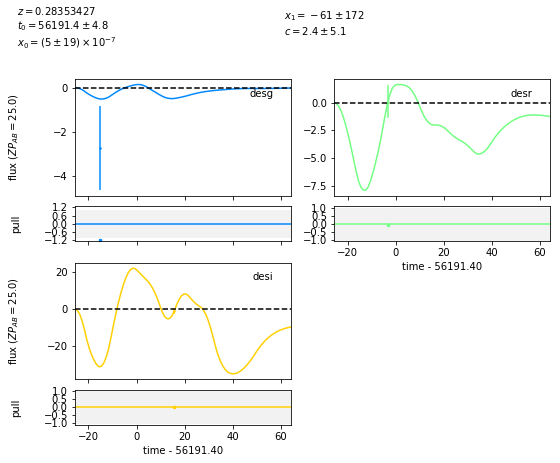

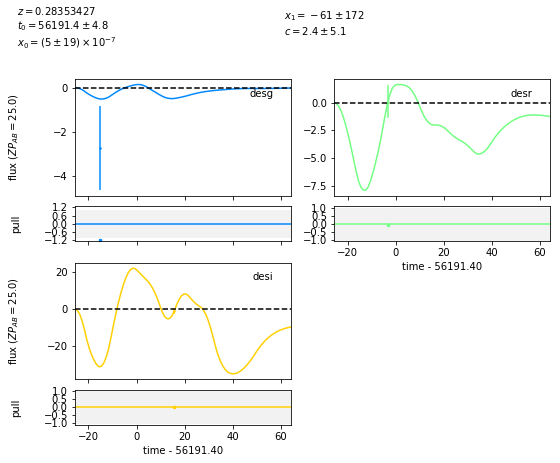

In [51]:
sncosmo.plot_lc(data1[200], model=fitted_model, errors=result.errors)

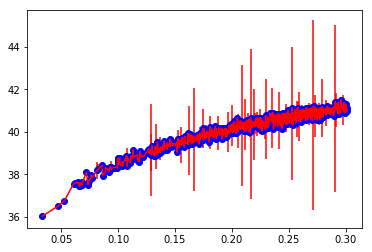

In [47]:
plt.errorbar(np.sort(zs), vals[Z], yerr= x1err/3e3, color="red")
plt.plot(np.sort(zs), vals[Z], "ob", label="")

#plt.plot(np.sort(zs), vals[Z], "b", label="")
#plt.plot(zs, vals, "bo", alpha=0.4, markeredgecolor="black", label="Fitted light-curve")